## 1. Introduction

The [plants dataset](https://archive.ics.uci.edu/dataset/180/plants), accessible on the plants dataset platform, comprises details about plant species and genera, including their presence in different states of the USA and Canada. Derived from the USDA plants database, this dataset is well-suited for employing clustering methods to examine patterns in plant distribution. With the robust features of PySpark, we can effectively import, handle, and cluster the data. The objective is to use clustering to detect sets of plant species sharing comparable geographic distributions. This investigation has the potential to provide meaningful insights into ecological connections and the geographical elements affecting the occurrence of plants.







In [ ]:
%%capture
!pip install matplotlib scikit-learn seaborn pyspark

## 2. Connection to Spark Cluster

To connect to the Spark cluster, we create a SparkSession object with the following params:

+ **appName:** application name displayed at the [Spark Master Web UI](http://localhost:8080/);
+ **master:** Spark Master URL, same used by Spark Workers;
+ **spark.executor.memory:** must be less than or equals to docker compose SPARK_WORKER_MEMORY config.

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder.appName("PlantClustering").getOrCreate()

## 3. Load Data


In [ ]:
import pandas as pd
import os
import time

In [ ]:
data_path = 'plants.data'
encoding = "ISO-8859-1"

# Initialize lists to hold the plant names and their occurrences
plant_names = []
plant_occurrences = []

# Parse the file
with open(data_path, 'r', encoding=encoding) as file:
    for line in file:
        parts = line.strip().split(',')
        plant_names.append(parts[0])
        plant_occurrences.append(parts[1:])

# Create a DataFrame where each row represents a plant and its occurrences
plants_df = pd.DataFrame({
    'Plant': plant_names,
    'Occurrences': plant_occurrences
})

# Display the first few rows of the transformed dataframe
plants_df.head()

,Plant,Occurrences
0,abelia,"[fl, nc]"
1,abelia x grandiflora,"[fl, nc]"
2,abelmoschus,"[ct, dc, fl, hi, il, ky, la, md, mi, ms, nc, s..."
3,abelmoschus esculentus,"[ct, dc, fl, il, ky, la, md, mi, ms, nc, sc, v..."
4,abelmoschus moschatus,"[hi, pr]"


## The exploratory data analysis provides two insightful visualizations:

1. **Distribution of Plant Occurrences by State**: This bar chart shows the number of plant occurrences in each state. It helps us understand which states have the highest diversity of plant species listed in the dataset.

2. **Distribution of the Number of States Each Plant is Found In**: The histogram reveals the distribution of the number of states across all plants in the dataset. It indicates how many plants are localized to a few states versus those that are widespread across many states.

With this understanding of the dataset, we can now proceed to implement clustering algorithms. We'll focus on:

**K-means Clustering**: To group plants based on their geographic distribution patterns.

**Bisecting K-means**: An alternative approach to K-means that might provide different insights.

**Gaussian Mixture Model (GMM)**: For a probabilistic approach to clustering, which can account for uncertainties in the data.

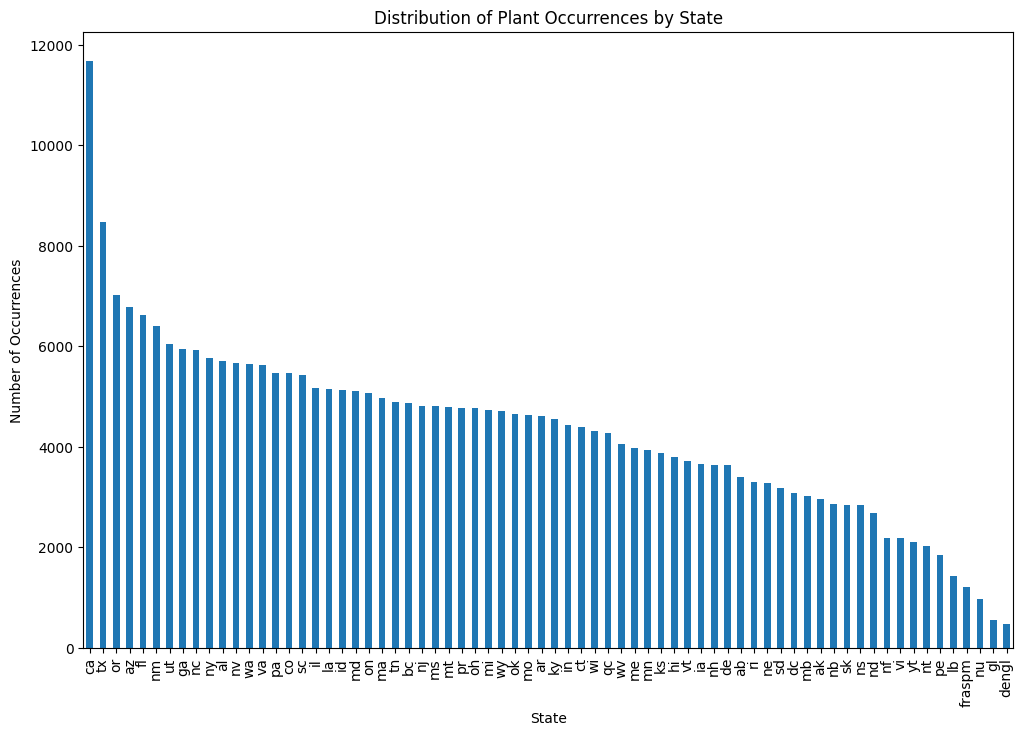

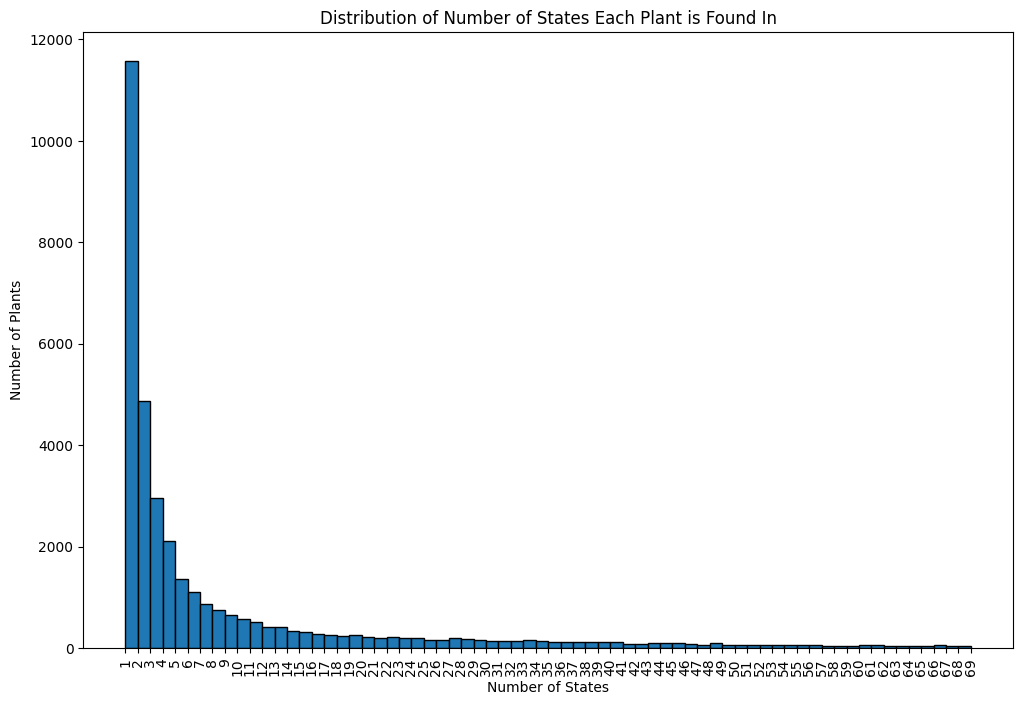

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each state across all plants
state_counts = pd.Series([state for sublist in plant_occurrences for state in sublist]).value_counts()

# Plot the distribution of plant occurrences by state
plt.figure(figsize=(12, 8))
state_counts.plot(kind='bar')
plt.title('Distribution of Plant Occurrences by State')
plt.xlabel('State')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.show()

# Count the number of states each plant is found in and plot the distribution
plants_df['NumStates'] = plants_df['Occurrences'].apply(len)
plt.figure(figsize=(12, 8))
plants_df['NumStates'].hist(bins=range(1, plants_df['NumStates'].max()+1), edgecolor='black')
plt.title('Distribution of Number of States Each Plant is Found In')
plt.xlabel('Number of States')
plt.ylabel('Number of Plants')
plt.xticks(range(1, plants_df['NumStates'].max()+1), rotation=90)
plt.grid(False)
plt.show()

Given the nature of our data, where each plant's occurrences are listed as states, we'll need to transform this into a numerical format suitable for clustering. This might involve creating a binary matrix where each row represents a plant and each column represents a state, with a 1 indicating the presence of the plant in that state and a 0 otherwise.

In [ ]:
# Create PySpark DataFrame from Pandas
plants_spark_df = spark.createDataFrame(plants_df)
plants_spark_df.printSchema()
plants_spark_df.show()

root
 |-- Plant: string (nullable = true)
 |-- Occurrences: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumStates: long (nullable = true)

+--------------------+--------------------+---------+
|               Plant|         Occurrences|NumStates|
+--------------------+--------------------+---------+
|              abelia|            [fl, nc]|        2|
|abelia x grandiflora|            [fl, nc]|        2|
|         abelmoschus|[ct, dc, fl, hi, ...|       15|
|abelmoschus escul...|[ct, dc, fl, il, ...|       14|
|abelmoschus mosch...|            [hi, pr]|        2|
|               abies|[ak, az, ca, co, ...|       47|
|          abies alba|                [nc]|        1|
|      abies amabilis|[ak, ca, or, wa, bc]|        5|
|      abies balsamea|[ct, in, ia, me, ...|       29|
|abies balsamea va...|[ct, in, ia, me, ...|       29|
|abies balsamea va...|[me, nh, vt, va, ...|       11|
|     abies bracteata|                [ca]|        1|
|      abies conco

In [ ]:
from pyspark.sql.functions import col, explode, collect_list, lit
from pyspark.sql import functions as F

# Assuming plants_df is already loaded into PySpark as a DataFrame
# Convert the "Occurrences" column from a list of states to a DataFrame row per state
plants_exploded_df = plants_spark_df.withColumn("State", explode(col("Occurrences")))

# Group by plant and pivot on state to create a binary matrix
binary_matrix_df = plants_exploded_df.groupBy("Plant").pivot("State").agg(F.lit(1)).na.fill(0)

# The binary matrix is now represented by binary_matrix_df, where each column is a state
# and each row represents a plant with 1s and 0s indicating the presence or absence in that state

# Show the first few rows of the binary matrix dataframe and its shape
binary_matrix_df.show()
print(f"DataFrame Shape: ({binary_matrix_df.count()}, {len(binary_matrix_df.columns)})")

+--------------------+---+---+---+---+---+---+---+---+---+---+---+-----+---+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|               Plant| ab| ak| al| ar| az| bc| ca| co| ct| dc| de|dengl| fl|fraspm| ga| gl| hi| ia| id| il| in| ks| ky| la| lb| ma| mb| md| me| mi| mn| mo| ms| mt| nb| nc| nd| ne| nf| nh| nj| nm| ns| nt| nu| nv| ny| oh| ok| on| or| pa| pe| pr| qc| ri| sc| sd| sk| tn| tx| ut| va| vi| vt| wa| wi| wv| wy| yt|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+-----+---+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|     cannabis sativa|  0|  0|  1|  1|  1|  0|  1|  1|  1|  1|  1|    0|  1|

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml import Pipeline

In [ ]:
# Prepare the Data
# Select the region columns for clustering
region_columns = binary_matrix_df.columns[1:]

# Convert the binary matrix into a vector column named "features"
assembler = VectorAssembler(inputCols=region_columns, outputCol="features")
feature_vector = assembler.transform(binary_matrix_df.drop('Plant'))

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# K-means

In [ ]:
# Initialize KMeans and ClusteringEvaluator
kmeans = KMeans(seed=42, featuresCol="features", predictionCol="prediction")

# Create a ParamGridBuilder and build the grid
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, range(2, 21)) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=kmeans,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(feature_vector)

# Get the best model
bestModel = cvModel.bestModel

# Show the best k
print(f"Best k: {bestModel.getK()}")

# You can also evaluate the best model directly to get its silhouette score
kmeans_silhouette = evaluator.evaluate(bestModel.transform(feature_vector))
print(f"Best model silhouette score: {kmeans_silhouette}")

Best k: 2
Best model silhouette score: 0.7181780188904243


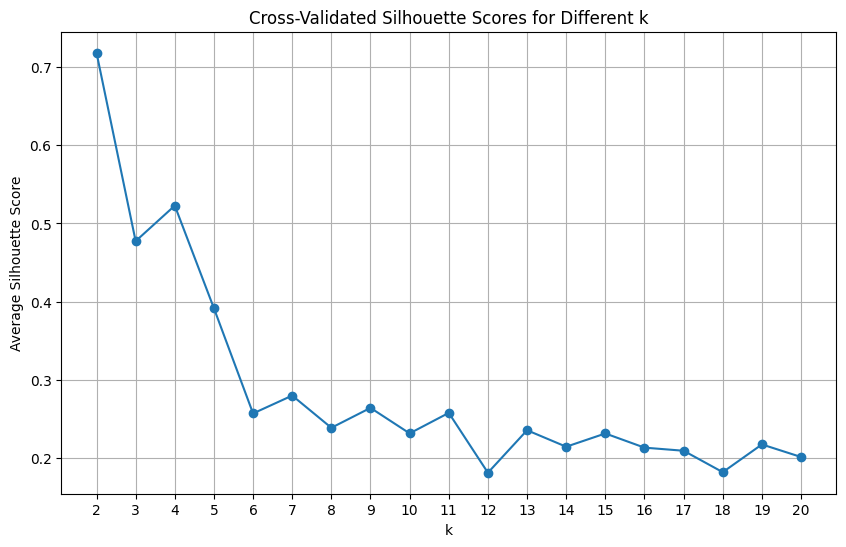

In [ ]:
avgMetrics = cvModel.avgMetrics

# The ks list corresponds to the range of k values tested
ks = range(2, 21)

# Plotting the average metrics (e.g., silhouette scores) for each k
plt.figure(figsize=(10, 6))
plt.plot(list(ks), avgMetrics, marker='o')
plt.title('Cross-Validated Silhouette Scores for Different k')
plt.xlabel('k')
plt.ylabel('Average Silhouette Score')
plt.xticks(list(ks))
plt.grid(True)
plt.show()

# Gaussian Mixture

In [ ]:
# Define the GMM model
gmm = GaussianMixture(featuresCol="features", predictionCol="prediction")

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(gmm.k, [2, 4, 6, 8]) \
    .addGrid(gmm.tol, [0.1, 0.9, 2]) \
    .build()

# Define the cross-validator
crossval = CrossValidator(estimator=gmm,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator)

# Fit the cross-validator to the data
GMM_model = crossval.fit(feature_vector)

# Get the best GMM model
best_gmm_model = GMM_model.bestModel

# Get the best K from the best model
best_k = best_gmm_model.getK()

# Evaluate the best GMM model
gmm_predictions = best_gmm_model.transform(feature_vector)
gmm_silhouette = evaluator.evaluate(gmm_predictions)

# Print the best K and its Silhouette score
print("Best K:", best_k)
print("GMM Silhouette Score:", gmm_silhouette)

Best K: 2
GMM Silhouette Score: 0.445032236052138


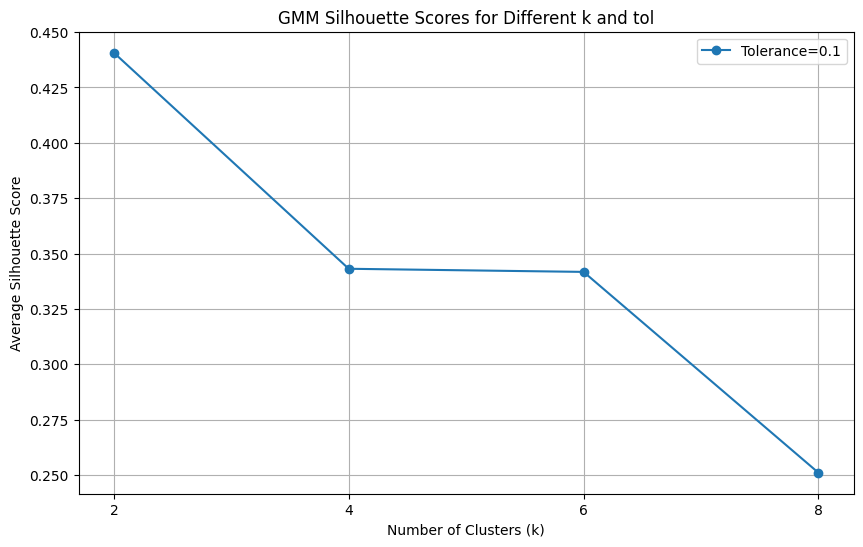

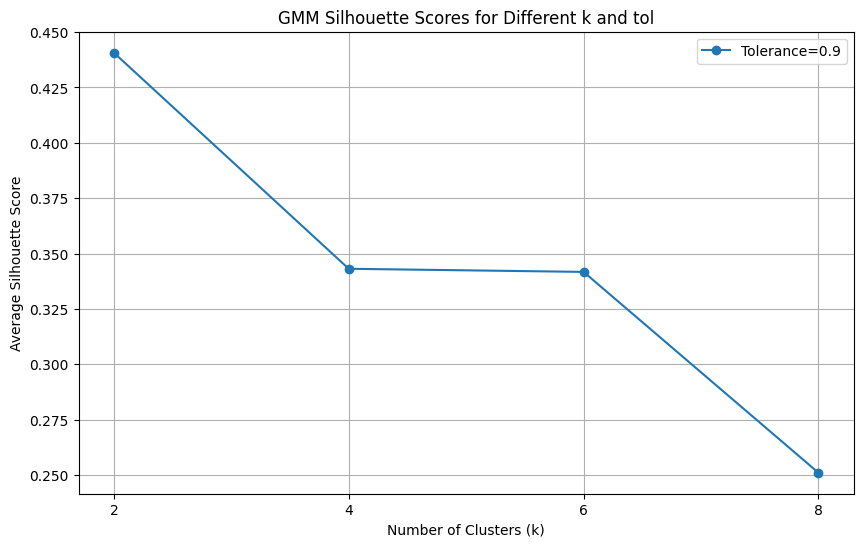

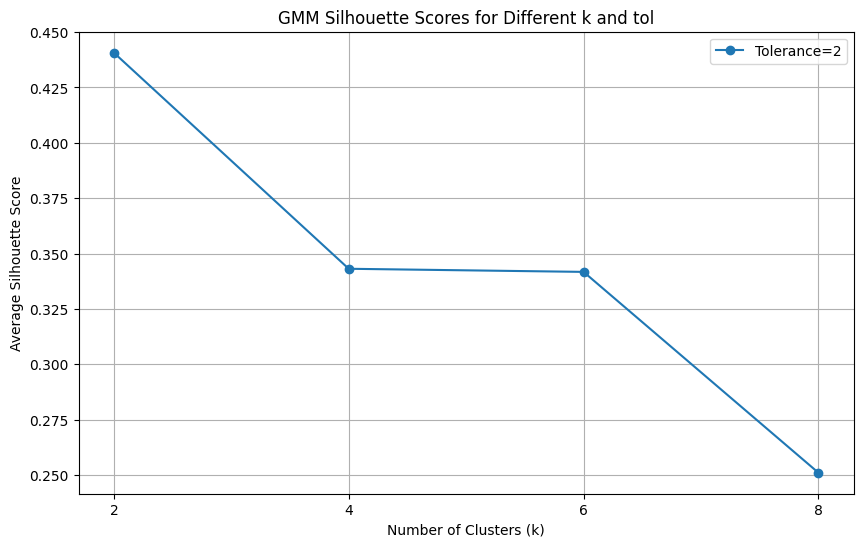

In [ ]:
import numpy as np

# Extract average metrics for each parameter combination
avgMetrics = np.array(GMM_model.avgMetrics)

# Since we have two parameters (k and tol), reshape avgMetrics to a 2D array for easier handling
# The reshaping dimensions are based on the lengths of the parameter grid lists for k and tol
metrics_matrix = avgMetrics.reshape(len([2, 4, 6, 8]), len([0.1, 0.9, 2]))

# Plotting
ks = [2, 4, 6, 8]
tols = [0.1, 0.9, 2]

for i, tol in enumerate(tols):
    plt.figure(figsize=(10, 6))
    plt.plot(ks, metrics_matrix[:, i], marker='o', label=f'Tolerance={tol}')
    plt.title('GMM Silhouette Scores for Different k and tol')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)
    plt.show()

# Bisecting KMeans

In [ ]:
# Define the Bisecting K-means model
bisecting_kmeans = BisectingKMeans(featuresCol="features", predictionCol="prediction")

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(bisecting_kmeans.k, [2, 3, 4, 5, 6, 7, 8]) \
    .addGrid(bisecting_kmeans.maxIter, [2, 5]) \
    .build()

# Define the cross-validator
crossval = CrossValidator(estimator=bisecting_kmeans,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator)

# Fit the cross-validator to the data
crossval_model = crossval.fit(feature_vector)

# Get the best Bisecting K-means model
best_bisecting_kmeans_model = crossval_model.bestModel

# Get the best K and maxIter values
best_k = best_bisecting_kmeans_model.getK()
best_maxIter = best_bisecting_kmeans_model.getMaxIter()

# Evaluate the best Bisecting K-means model
bisecting_kmeans_predictions = best_bisecting_kmeans_model.transform(feature_vector)
bisecting_kmeans_silhouette = evaluator.evaluate(bisecting_kmeans_predictions)

# Print the best K, maxIter, and its Silhouette score
print("Best K:", best_k)
print("Best maxIter:", best_maxIter)
print("Bisecting K-means Silhouette Score:", bisecting_kmeans_silhouette)

Best K: 2
Best maxIter: 5
Bisecting K-means Silhouette Score: 0.7176344008826809


# Credit Project work

In [ ]:
from pyspark.ml.clustering import LDA
import matplotlib.pyplot as plt


ks = range(2, 21)  # Example range of k values
logLikelihoods = []
logPerplexities = []

for k in ks:
    lda = LDA(k=k, maxIter=10, featuresCol="features")
    model = lda.fit(feature_vector)

    # Calculate metrics
    logLikelihood = model.logLikelihood(feature_vector)
    logPerplexity = model.logPerplexity(feature_vector)

    # Store metrics
    logLikelihoods.append(logLikelihood)
    logPerplexities.append(logPerplexity)

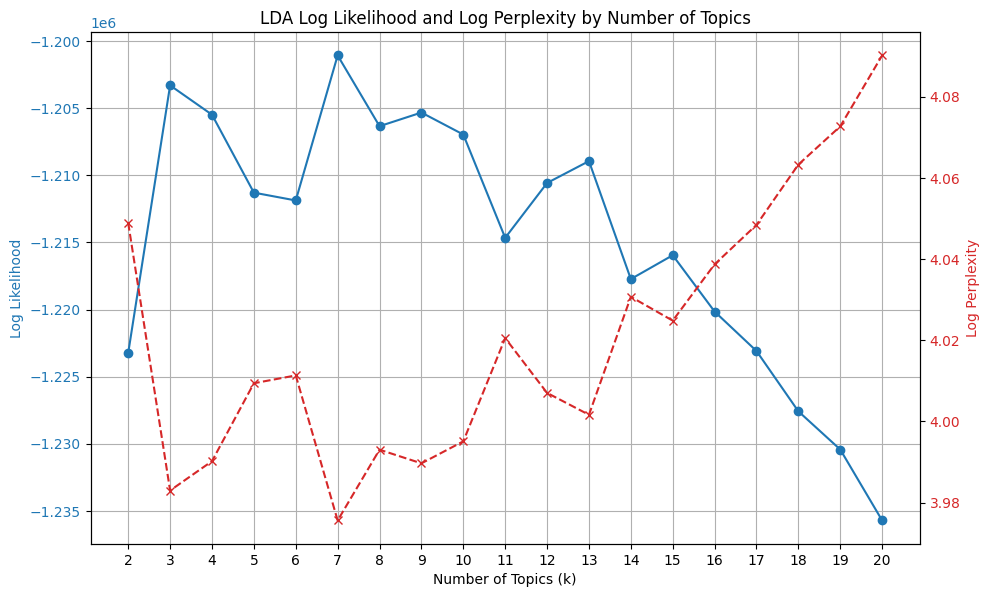

In [ ]:
import matplotlib.pyplot as plt

# Assuming logLikelihoods and logPerplexities have been calculated for ks = list(range(2, 21))
ks = list(range(2, 21))  # Every natural number from 2 to 20

# First, create separate plots for individual visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('Log Likelihood', color=color)
ax1.plot(ks, logLikelihoods, marker='o', linestyle='-', color=color, label='Log Likelihood')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Perplexity', color=color)
ax2.plot(ks, logPerplexities, marker='x', linestyle='--', color=color, label='Log Perplexity on Right')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ks)
fig.tight_layout()  # To make sure layout is nice
plt.title('LDA Log Likelihood and Log Perplexity by Number of Topics')
plt.show()


In [ ]:
from pyspark.ml.clustering import LDA

# Configure LDA
lda = LDA(k=7, maxIter=10, featuresCol="features")  # k is the number of topics

# Train the LDA model
ldaModel = lda.fit(feature_vector)
# Display topics
topics = ldaModel.describeTopics()  # You can specify the number of terms to display per topic
topics.show(truncate=False)

+-----+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                            |termWeights                                                                                                                                                                                                              |
+-----+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[29, 51, 66, 47, 8, 25, 20, 46, 19, 49]|[0.025878713929822748, 0.025854537334159464, 0.025715621018353858, 0.02541804549245377, 0.025407805349733567, 0.025216876389241583, 0.025073888142182067, 0

This table from the describeTopics() function of the LDA model with k equal to 7 shows two important pieces of information for each topic discovered by the model:

**termIndices**: Indices of the top terms in the topic.

**termWeights**: Weights of these top terms within the topic, indicating their importance or contribution to the topic.


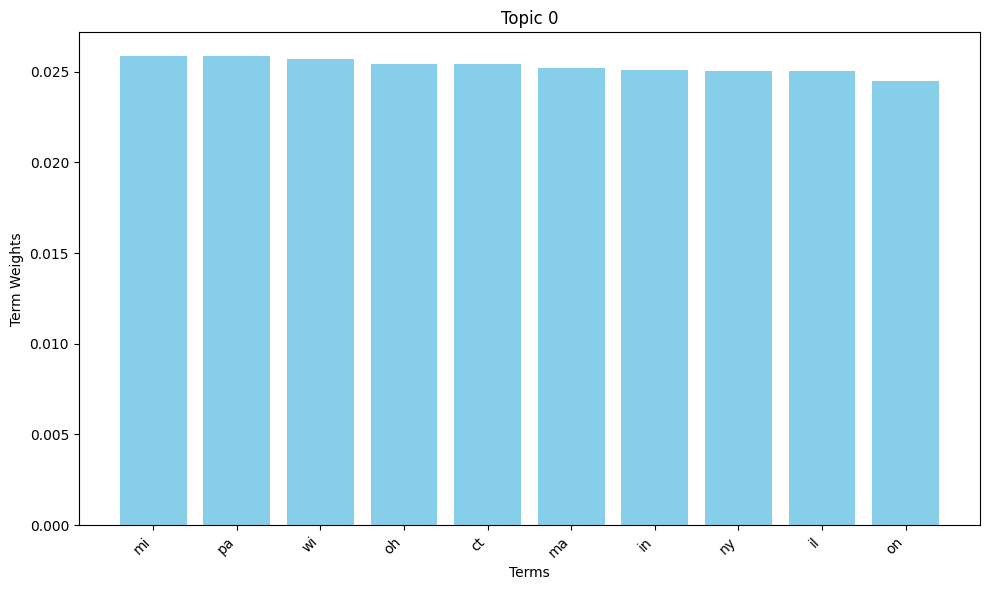

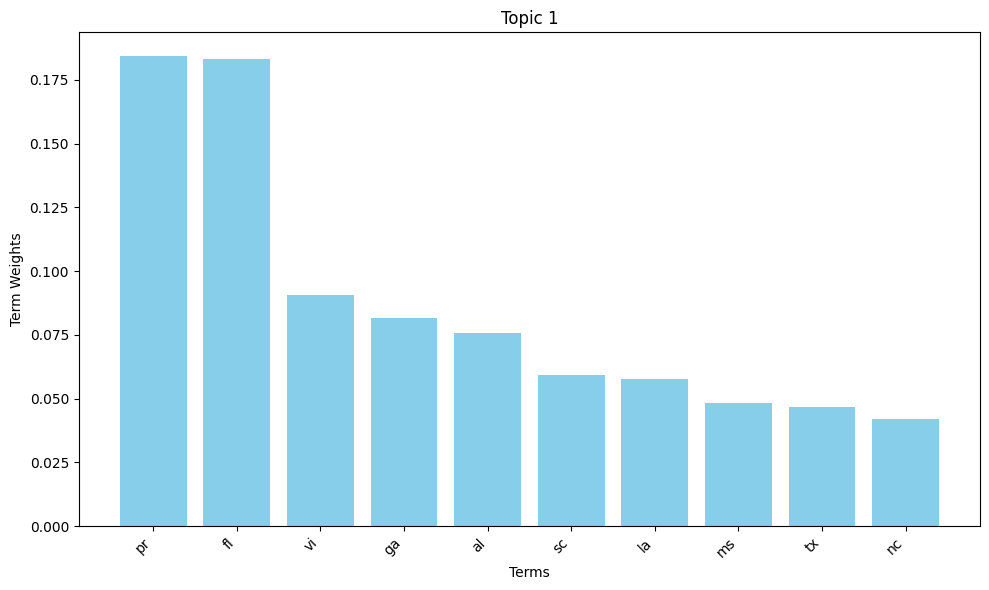

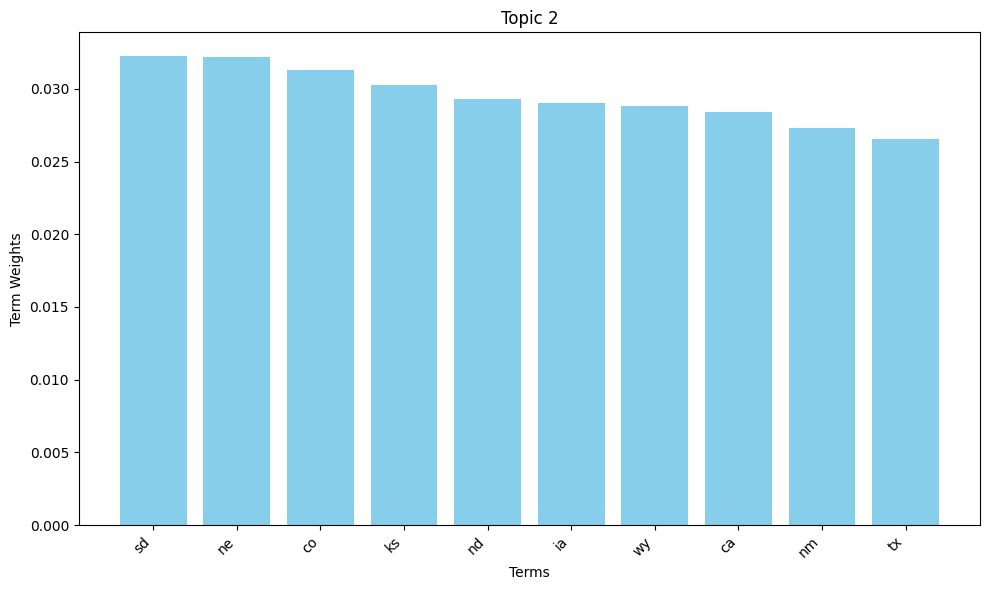

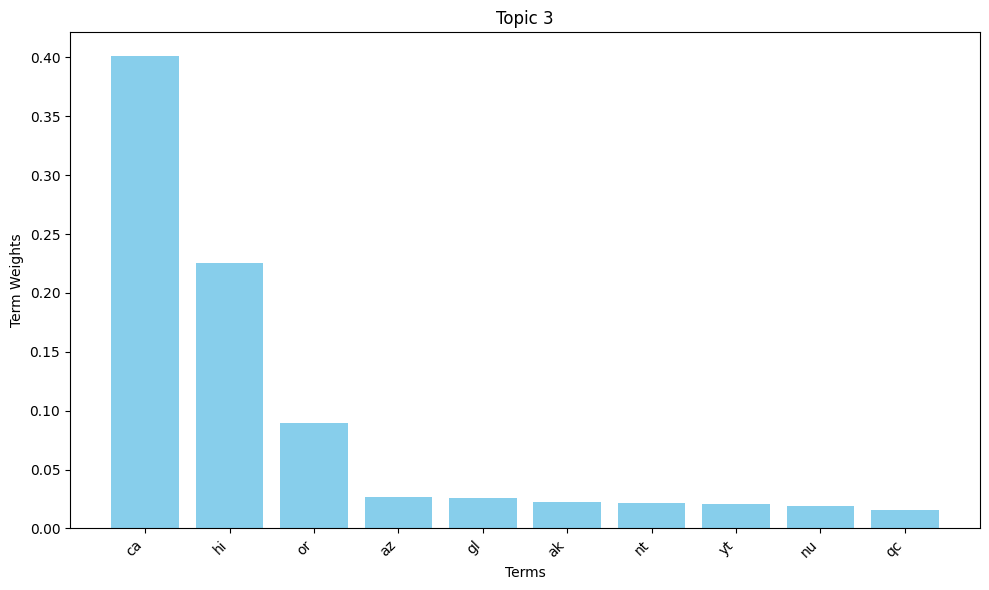

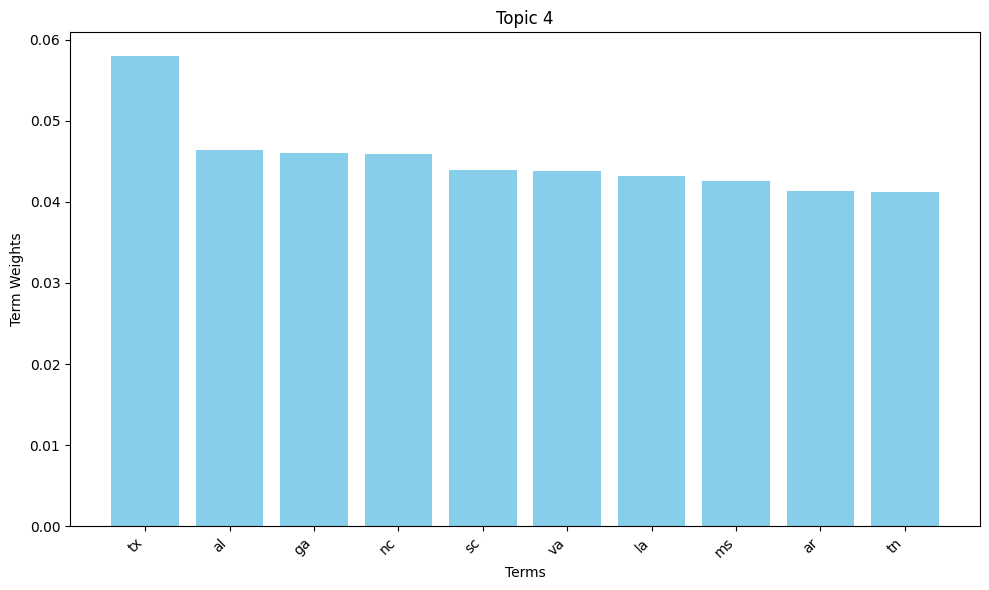

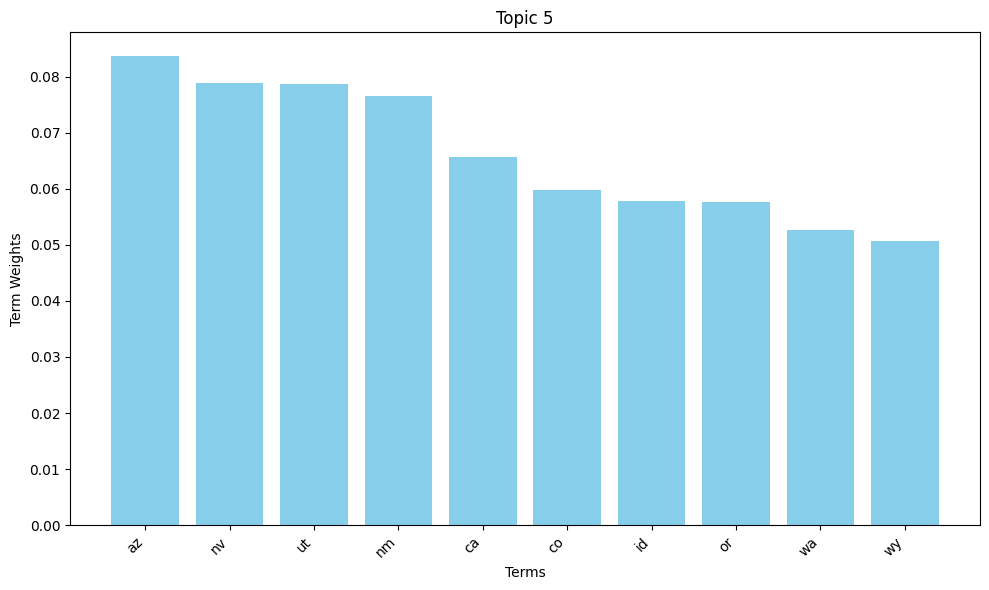

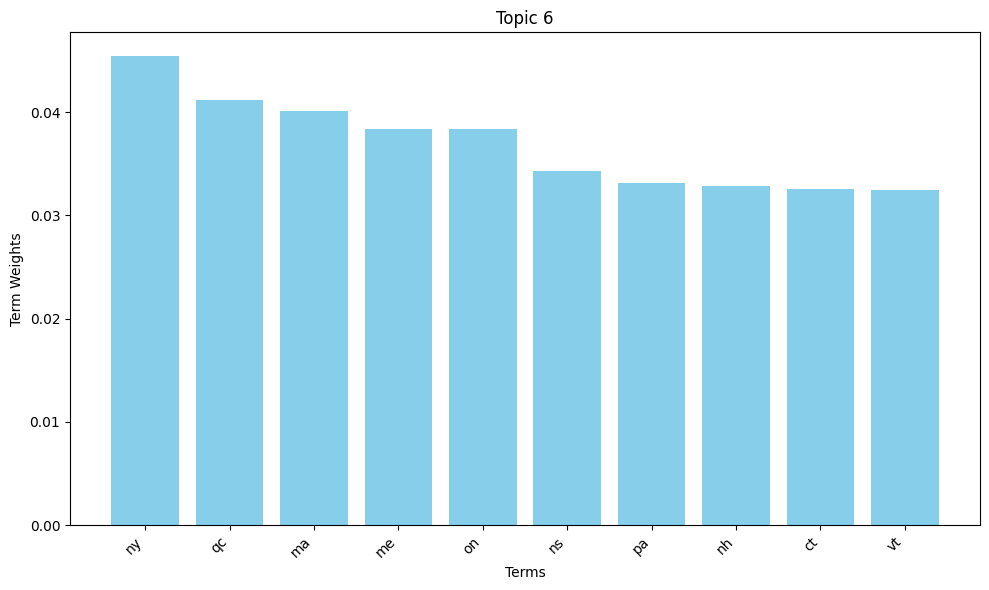

In [ ]:
# Collecting topics data (ensure your Spark environment can handle the collected data in driver memory)
topics_data = topics.select("topic", "termIndices", "termWeights").collect()

for topic in topics_data:
    topic_id = topic['topic']
    term_indices = topic['termIndices']
    term_weights = topic['termWeights']

    # Map term indices to words
    terms = [region_columns[index] for index in term_indices]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(terms, term_weights, color='skyblue')
    plt.title(f'Topic {topic_id}')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Term Weights')
    plt.xlabel('Terms')

    plt.tight_layout()
    plt.show()
